In [ ]:
from utils import *
import json
import torch

%load_ext autoreload
%autoreload 2

In [27]:
webkb_config = json.load( open('reut_w=5_nh=4_lr=0.00100_l2=0.00100_bs=16.json') )
model_filename = webkb_config['folds'][0]['model']

In [28]:
model = torch.load(model_filename)

In [29]:
print(model)

ClassifierGAT(
  (encoder): Linear(in_features=300, out_features=300, bias=True)
  (layers): ModuleList(
    (0): GATConv(
      (fc): Linear(in_features=300, out_features=1200, bias=False)
      (feat_drop): Dropout(p=0.5, inplace=False)
      (attn_drop): Dropout(p=0.3, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (1): GATConv(
      (fc): Linear(in_features=1200, out_features=1200, bias=False)
      (feat_drop): Dropout(p=0.5, inplace=False)
      (attn_drop): Dropout(p=0.3, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
  (lin): Linear(in_features=1500, out_features=1, bias=True)
  (pooling): GlobalAttentionPooling(
    (gate_nn): Linear(in_features=1500, out_features=1, bias=True)
  )
  (norm): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (classify): Linear(in_features=1500, out_features=90, bias=True)
)


In [30]:
from dgl.nn.pytorch.softmax import edge_softmax
from dgl import function as fn
from dgl.batched_graph import softmax_nodes, sum_nodes

In [31]:
def explain(self, G):
    with torch.no_grad():
        h = G.ndata['f']
        he = self.encoder(h)
        h = he
        h = self.layers[0](G, h)
        h = h.view(h.shape[0], -1)
        
        ###################### Begin explain second GAT layer ######################
        h = _explain_gat_(self.layers[1], G, h)
        h = h.view(h.shape[0], -1)
        ###################### End explain second GAT layer ######################
        
        hg = torch.cat((h,he), 1)
        hg = self.norm( hg )
        hg = self.drop( hg )
        
        ###################### Begin explain Global Attention ######################
        hg = _explain_global_att_(self.pooling, G, hg)
        ###################### End explain Global Attention ######################
        
        ###################### Begin unbatch and convertion to networkx ######################
        Gs = dgl.unbatch(G)
        Gs_nx = []
        for g in Gs:
            g_nx = g.to_networkx(node_attrs=['idx', 'gate', 'r'], edge_attrs=['a'])
            new_graph = nx.DiGraph()
            new_graph.add_nodes_from( [( graph_builder.vocab_idx[att_node['idx'].item()],
                                        { 'weight': att_node['gate'].item(),
                                          'vector': att_node['r'].cpu().numpy() } )
                                       for (id_node, att_node) in g_nx.nodes(data=True)] )
            w_edges = [(graph_builder.vocab_idx[g_nx.nodes[s_id]['idx'].item()],
                        graph_builder.vocab_idx[g_nx.nodes[t_id]['idx'].item()],
                        att['a'].cpu().numpy()) for ( s_id, t_id, att ) in g_nx.edges(data=True)]
            new_graph.add_weighted_edges_from( w_edges, weight='weight' )
            Gs_nx.append( new_graph )
        ###################### End explain Global Attention ######################
        
        return Gs_nx
def _explain_gat_(self, G, feat):
    graph = G.local_var()
    h = self.feat_drop(feat)
    feat = self.fc(h).view(-1, self._num_heads, self._out_feats)
    el = (feat * self.attn_l).sum(dim=-1).unsqueeze(-1)
    er = (feat * self.attn_r).sum(dim=-1).unsqueeze(-1)
    graph.ndata.update({'ft': feat, 'el': el, 'er': er})
    # compute edge attention
    graph.apply_edges(fn.u_add_v('el', 'er', 'e'))
    e = self.leaky_relu(graph.edata.pop('e'))
    # compute softmax
    G.edata['a'] = edge_softmax(graph, e)
    graph.edata['a'] = self.attn_drop(edge_softmax(graph, e))
    # message passing
    graph.update_all(fn.u_mul_e('ft', 'a', 'm'), fn.sum('m', 'ft'))
    rst = graph.ndata['ft']
    # residual
    if self.res_fc is not None:
        resval = self.res_fc(h).view(h.shape[0], -1, self._out_feats)
        rst = rst + resval
    # activation
    if self.activation:
        rst = self.activation(rst)
    return rst
def _explain_global_att_(self, G, feat):
    graph = G.local_var()
    gate = self.gate_nn(feat)
    assert gate.shape[-1] == 1, "The output of gate_nn should have size 1 at the last axis."
    feat = self.feat_nn(feat) if self.feat_nn else feat

    graph.ndata['gate'] = gate
    gate = softmax_nodes(graph, 'gate')
    G.ndata['gate'] = gate
    graph.ndata.pop('gate')

    graph.ndata['r'] = feat * gate
    G.ndata['r'] = feat * gate
    readout = sum_nodes(graph, 'r')
    #graph.ndata.pop('r')

    return readout

In [2]:
from utils import Dataset, GraphsizePretrained
from torch.utils.data import DataLoader

from TGA_model import GraphsizePretrained,  ClassifierGAT, TGA

In [3]:
reut = Dataset('../../../datasets/topics/reut/')
fold = next( reut.get_fold_instances(10) )
fold._fields

('X_train', 'y_train', 'X_test', 'y_test', 'X_val', 'y_val')

In [4]:
reut.available_splits

{'10', '5'}

In [7]:
len(reut.get_split(5)), len(reut.get_split(5)[0]), 

(5, 3)

In [37]:
graph_builder = GraphsizePretrained(verbose=True, w=5, pretrained_vec='/home/mangaravite/Documents/pretrained_vectors/glove.6B.300d.txt')

400000it [00:20, 19396.95it/s]


In [38]:
Gs_train = graph_builder.fit_transform( fold.X_train )
Gs_test = graph_builder.transform( fold.X_test )

100%|██████████| 1350/1350 [00:01<00:00, 736.42it/s]


In [54]:
"""
Código para gerar posição específica dos nodes
import networkx as nx
G=nx.Graph()
G.add_node(1,pos=(1,1))
G.add_node(2,pos=(2,2))
G.add_edge(1,2)
pos=nx.get_node_attributes(G,'pos')
pos
Out[7]: {1: (1, 1), 2: (2, 2)}
nx.draw(G,pos)
"""

"""
Código para colocar cor e width específica para edges:
edges = G.edges()
colors = [mapper[u][v]['color'] for u,v in edges]
weights = [mapper[u][v]['weight'] for u,v in edges]

nx.draw(G, pos, edges=edges, edge_color=colors, width=weights)
"""

"\nCódigo para Gerar posição específica dos nodes\nimport networkx as nx\nG=nx.Graph()\nG.add_node(1,pos=(1,1))\nG.add_node(2,pos=(2,2))\nG.add_edge(1,2)\npos=nx.get_node_attributes(G,'pos')\npos\nOut[7]: {1: (1, 1), 2: (2, 2)}\nnx.draw(G,pos)"

In [39]:
def collate_test(samples):
    Gs_Fs = samples
    graphs = []
    for g, f in Gs_Fs:
        g_dgl = dgl.DGLGraph()
        g_dgl.from_networkx(g, node_attrs=['idx'])
        g_dgl.ndata['f'] = torch.FloatTensor(f).to(torch.device('cuda:0'))
        g_dgl.to(torch.device('cuda:0'))
        graphs.append(g_dgl)
    batched_graph = dgl.batch(graphs)
    batched_graph.to(torch.device('cuda:0'))
    return batched_graph 

In [40]:
data_loader = DataLoader(Gs_test[:5], batch_size=16,
                         shuffle=False, collate_fn=collate_test)
for i,G in enumerate(data_loader):
    Gs_0 = G
    break

In [41]:
import matplotlib.pyplot as plt

In [188]:
G2 = explain(model, Gs_0)
G_explained = G2[1]

In [189]:
G_explained.nodes(data=True)

NodeDataView({'the': {'weight': 0.0026447507552802563, 'vector': array([ 9.0902614e-07, -6.4362364e-04, -8.9507102e-04, ...,
       -3.5591688e-04, -6.0547917e-04,  1.9756518e-04], dtype=float32)}, 'of': {'weight': 0.0026936326175928116, 'vector': array([ 9.2682097e-07, -6.4896327e-04, -8.5091050e-04, ...,
       -5.9493852e-04, -2.8049032e-04, -2.2174798e-05], dtype=float32)}, 'to': {'weight': 0.0024351119063794613, 'vector': array([ 8.3447213e-07, -5.9223844e-04, -7.5679581e-04, ...,
       -4.6830354e-04, -9.3721435e-04,  9.6540163e-05], dtype=float32)}, 'and': {'weight': 0.0023513459600508213, 'vector': array([ 8.0426298e-07, -5.6979549e-04, -7.6446804e-04, ...,
       -2.5297183e-04,  2.6103976e-04, -2.0887644e-05], dtype=float32)}, 'in': {'weight': 0.0024439250119030476, 'vector': array([ 8.3660296e-07, -5.9685891e-04, -7.6120038e-04, ...,
       -2.6888979e-04,  4.0129243e-04,  3.5093481e-06], dtype=float32)}, 'for': {'weight': 0.0025497220922261477, 'vector': array([ 8.7959597e

In [190]:
nodes = G_explained.nodes
h_nodes = [ G_explained.nodes[n]['vector'] for n in nodes]
h_nodes = np.stack(h_nodes)
h_nodes.shape

(93, 1500)

In [191]:
from sklearn.manifold import TSNE

In [192]:
tsne = TSNE()
h_nodes_2d = tsne.fit_transform( h_nodes )

In [193]:
pos_tsne = dict( [ (n,tuple(a)) for (n,a) in zip(nodes, h_nodes_2d) ] )

array([0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01])

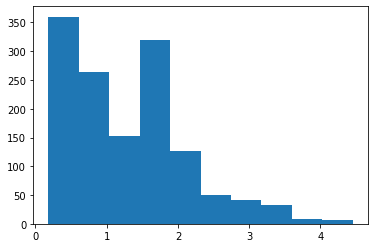

In [194]:
edges_list = G_explained.edges
edge_weights = np.array([ G_explained.edges[(s,t)]['weight'] for (s,t) in edges_list ])
edge_weights = (edge_weights / edge_weights.mean(axis=0)).max(axis=1).reshape( -1 )
counts, bins, dtype = plt.hist(edge_weights)
all_sizes    = list(zip(bins[-4:-1], [.3, .5, .7]))

initial_size = .01
edge_width = np.full( len(edges_list), initial_size )


for criterion,v in all_sizes:
    idx = edge_weights > criterion
    edge_width[idx] = v
edge_width

In [195]:
all_sizes, bins[-7:-1],bins[-4:],

([(3.1723523, 0.3), (3.5995271, 0.5), (4.026702, 0.7)],
 array([1.8908283, 2.318003 , 2.7451777, 3.1723523, 3.5995271, 4.026702 ],
       dtype=float32),
 array([3.1723523, 3.5995271, 4.026702 , 4.4538765], dtype=float32))

In [196]:
min_value = bins[np.abs(np.diff(counts)).argmax()+1]
max_value = bins[-1]
(max_value-min_value)/3

0.8543494542439779

(array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 300, 100, 100, 100, 100, 100, 100, 100, 600, 100, 100, 300,
        100, 100, 100, 100, 300, 100, 100, 100, 300, 100, 300, 300, 100,
        100, 900, 100, 300, 100, 100, 100, 100, 900, 300, 100, 100, 100,
        100, 100, 100, 100, 100, 300, 600, 100, 100, 300, 100, 100, 100,
        100, 300, 100, 100, 300, 300, 600, 100, 600, 300, 100, 300, 100,
        300, 100, 100, 100, 100, 300, 100, 100, 600, 300, 100, 300, 100,
        600, 100]),
 array(['whitesmoke', 'whitesmoke', 'whitesmoke', 'whitesmoke',
        'whitesmoke', 'whitesmoke', 'whitesmoke', 'whitesmoke',
        'whitesmoke', 'whitesmoke', 'whitesmoke', 'whitesmoke',
        'whitesmoke', 'whitesmoke', 'lightcoral', 'whitesmoke',
        'whitesmoke', 'whitesmoke', 'whitesmoke', 'whitesmoke',
        'whitesmoke', 'whitesmoke', 'indianred', 'whitesmoke',
        'whitesmoke', 'lightcoral', 'whitesmoke', 'whitesmoke',
        'whitesmoke', 

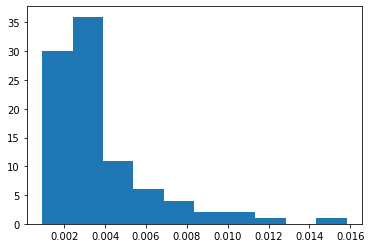

In [197]:
initial_size = 100
k=3
nbins=10

node_weights = np.array([ G_explained.nodes[n]['weight'] for n in G_explained.nodes ])
counts, bins, _ = plt.hist(node_weights, bins=nbins)
min_value  = bins[np.abs(np.diff(counts)).argmax()+1]
max_value  = bins[-1]
iter_value = (max_value-min_value)/k

intervals = [ i*iter_value+min_value for i in range(k) ]

all_sizes    = list(zip(intervals, [300, 600, 900], ['lightcoral', 'indianred', 'red']))

node_sizes = np.full( len(node_weights), initial_size )
node_color = np.full( len(node_weights), 'whitesmoke' )
for l,v,c in all_sizes:
    idx = node_weights >= l
    node_sizes[idx] = v
    node_color[idx] = c
node_sizes, node_color, Counter(node_sizes), Counter(node_color)

In [198]:
#pos=nx.spring_layout(G_explained,k=5,iterations=120)
pos=pos_tsne
#pos=nx.circular_layout(G2[0])
#pos=nx.kamada_kawai_layout(G2[0])
#pos=nx.random_layout(G2[0])
#pos=nx.rescale_layout(G2[0])
#pos=nx.spectral_layout(G2[0])
#pos=nx.spiral_layout(G2width[0])


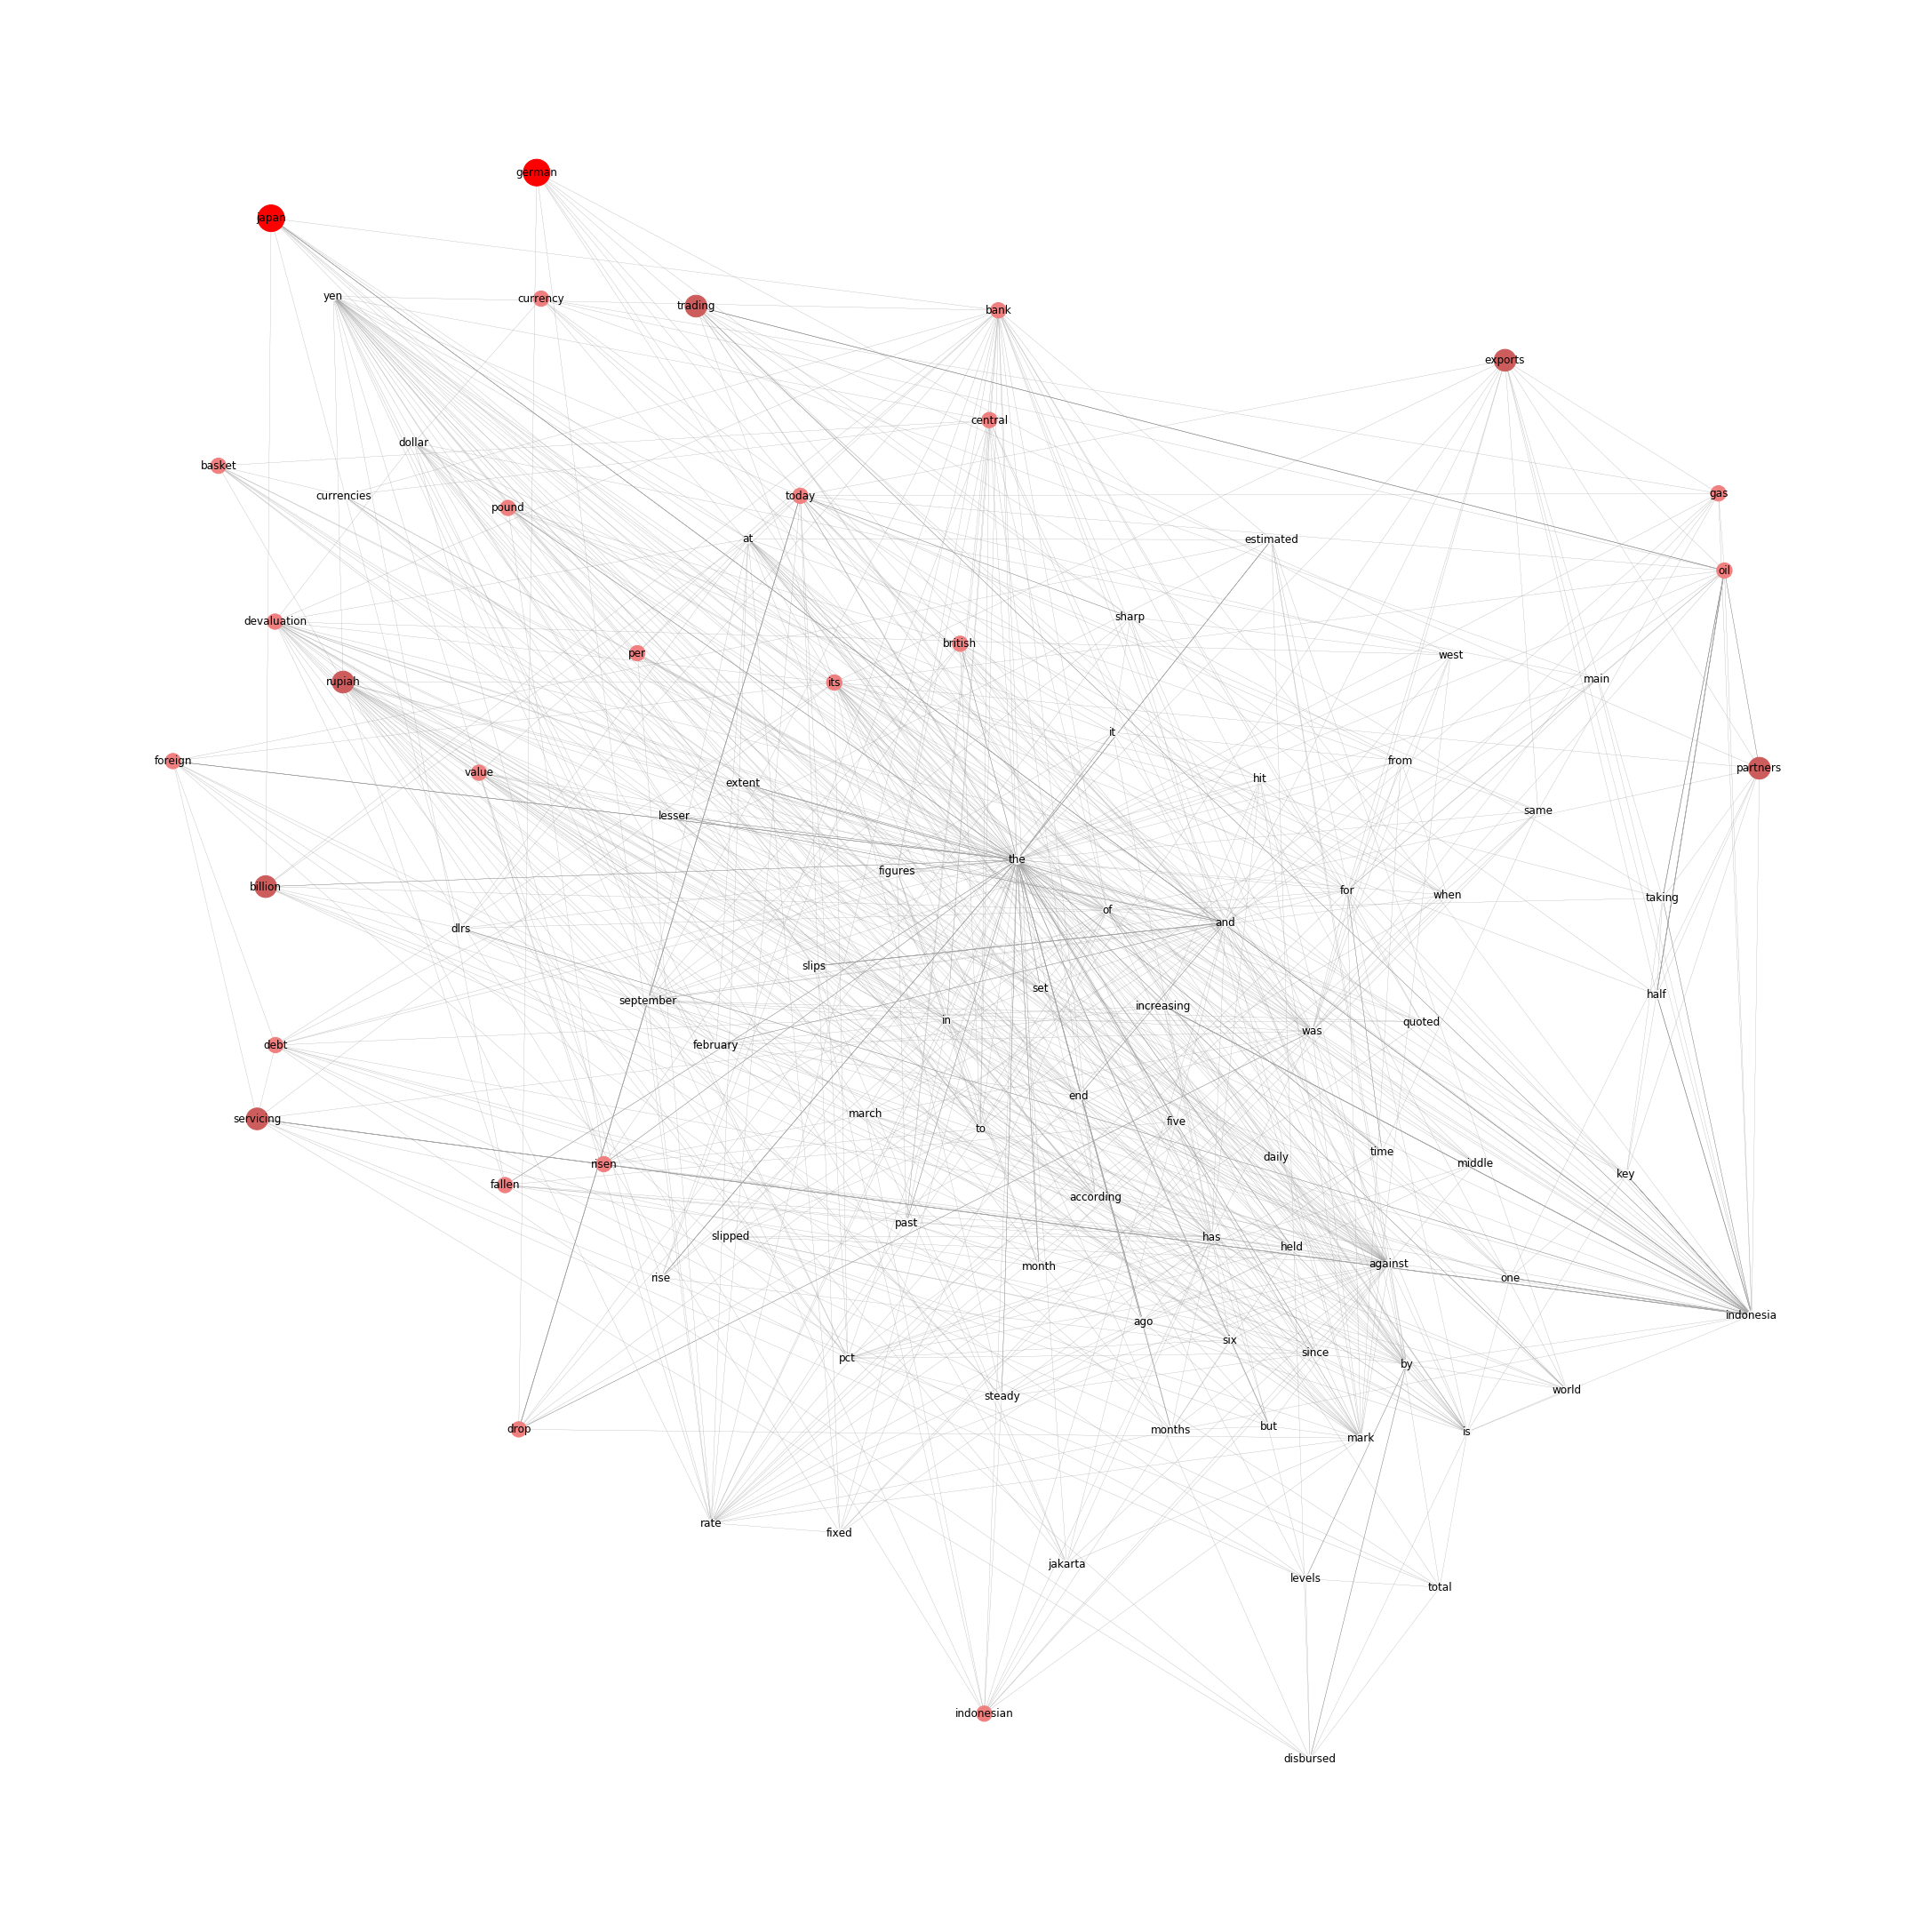

In [199]:
plt.figure(1,figsize=(30,30)) 
nx.draw(G_explained, with_labels=True,
        edge_color = 'darkgray', node_color = node_color,
        arrowsize=.5, arrowstyle='fancy',
        width=edge_width,  edges=edges_list,
        #edges=edges, edge_color=colors, width=weights
        node_size=node_sizes, pos=pos)
plt.show()

In [120]:
import networkx as nx